In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import os
import sys
import glob
import re
import pickle
import random

import wave
import librosa as lb
import librosa.display as lbd
from python_speech_features import *
import soundfile as sf
import io
from IPython.display import Audio

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf = tf.compat.v1
tf.disable_v2_behavior()
tf.disable_eager_execution()

import tensorflow_hub as hub

2025-07-21 23:00:04.667154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 23:00:04.685669: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 23:00:04.842732: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-21 23:00:04.982407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753119005.127396    2815 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753119005.17

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import loupe_keras as lpk

sys.path.append('/home/smrutibiswal/Research/SpeechOnly/models-master/research/audioset/vggish')
import vggish_input as vggish_input
import vggish_params as vggish_params
import vggish_postprocess as vggish_postprocess
import vggish_slim as vggish_slim

import csv

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


## Loading Data


In [ ]:
data_csv_path = '/home/smrutibiswal/Research/Dataset/labels/edited'
df = pd.read_csv(os.path.join(data_csv_path, 'Detailed_PHQ8_Labels.csv'))
df.head()

,Participant_ID,PHQ_8NoInterest,PHQ_8Depressed,PHQ_8Sleep,PHQ_8Tired,PHQ_8Appetite,PHQ_8Failure,PHQ_8Concentrating,PHQ_8Moving,PHQ_8Total
0,300,0,0,1,0,1,0,0,0,2
1,301,0,0,1,1,1,0,0,0,3
2,302,1,1,0,1,0,1,0,0,4
3,303,0,0,0,0,0,0,0,0,0
4,304,0,1,1,2,2,0,0,0,6


The above csv doesn't have the binary target coulmns. So we take train and test df and merge it to get the entire df.

In [ ]:
train_df = pd.read_csv(os.path.join(data_csv_path, 'train_split.csv'))
train_df = train_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

test_df = pd.read_csv(os.path.join(data_csv_path, 'dev_split.csv'))
test_df = test_df[['Participant_ID', 'Gender', 'PHQ_Binary', 'PHQ_Score']]

In [ ]:
print(f"Train set: {train_df.shape[0]} samples, Test set: {test_df.shape[0]} samples")
print("Training Samples: ")
print(train_df.head())
print("Testing Samples: ")
print(test_df.head())

Train set: 148 samples, Test set: 48 samples
Training Samples: 
   Participant_ID   Gender  PHQ_Binary  PHQ_Score
0             302     male           0          4
1             303   female           0          0
2             304   female           0          6
3             305     male           0          7
4             307  female            0          4
Testing Samples: 
   Participant_ID  Gender  PHQ_Binary  PHQ_Score
0             300    male           0          2
1             301    male           0          3
2             306  female           0          0
3             317    male           0          8
4             320  female           0         11


In [ ]:
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by=['Participant_ID'])
df = df.reset_index(drop=True)
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score
0,300,male,0,2
1,301,male,0,3
2,302,male,0,4
3,303,female,0,0
4,304,female,0,6


In [ ]:
len(df)

196

In [ ]:
df.groupby('PHQ_Binary').count()

,Participant_ID,Gender,PHQ_Score
PHQ_Binary,,,
0,153,153,153
1,43,43,43


## Preprocessing

In [ ]:
train_df['Audio_Path'] = ''
test_df['Audio_Path'] = ''

train_audio_path = '/home/smrutibiswal/Research/Dataset/data/train/audios'
test_audio_path = '/home/smrutibiswal/Research/Dataset/data/validation/audios'

# counting audiofiles in train and test set
train_count = 0
for files in os.listdir(train_audio_path):
    if files.endswith('.wav'):
        train_count += 1

if train_count == len(train_df):
    print("Train set audio files count matches with the csv file")

test_count = 0
for files in os.listdir(test_audio_path):
    if files.endswith('.wav'):
        test_count += 1

if test_count == len(test_df):
    print("Test set audio files count matches with the csv file")


Train set audio files count matches with the csv file
Test set audio files count matches with the csv file


In [ ]:
for i in range(train_count):
    file_name = str(train_df['Participant_ID'][i]) + '_AUDIO.wav'
    train_df['Audio_Path'][i] = os.path.join(train_audio_path, file_name)

print("Train set audio files added to the dataframe")
train_df.head()

Train set audio files added to the dataframe


,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path
0,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...
1,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...
2,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...
3,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...
4,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...


In [ ]:
for i in range(len(test_df)):
    file_name = str(test_df['Participant_ID'][i]) + '_AUDIO.wav'
    test_df['Audio_Path'][i] = os.path.join(test_audio_path, file_name)

test_df.head()

# audio_play = test_df['Audio_Path'][int(random())]

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...
2,306,female,0,0,/home/smrutibiswal/Research/Dataset/data/valid...
3,317,male,0,8,/home/smrutibiswal/Research/Dataset/data/valid...
4,320,female,0,11,/home/smrutibiswal/Research/Dataset/data/valid...


In [ ]:
# delete previous existing df variable
df = None

# Concatenating train and test dataframes
df = pd.concat([train_df, test_df], axis=0)

# sorting by Participant_ID
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)

df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...


In [ ]:
train_df['Transcript'] = ''
test_df['Transcript'] = ''

train_trans_path = '/home/smrutibiswal/Research/Dataset/data/train/transcripts'
test_trans_path = '/home/smrutibiswal/Research/Dataset/data/validation/transcripts'

# counting transcripts in train and test set
train_count = 0
test_count = 0
for files in os.listdir(train_trans_path):
    if files.endswith('.csv'):
        train_count += 1

for files in os.listdir(test_trans_path):
    if files.endswith('.csv'):
        test_count += 1

if train_count == len(train_df):
    print("Train set transcript files count matches with the csv file")
if test_count == len(test_df):
    print("Test set transcript files count matches with the csv file")


Train set transcript files count matches with the csv file
Test set transcript files count matches with the csv file


In [ ]:
for i in range(len(train_df)):
    file_name = str(train_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    train_df['Transcript'][i] = os.path.join(train_trans_path, file_name)

print("Train set transcript files added to the dataframe")
train_df.head()

for i in range(len(test_df)):
    file_name = str(test_df['Participant_ID'][i])+'_TRANSCRIPT.csv'
    test_df['Transcript'][i] = os.path.join(test_trans_path, file_name)
print("Test set transcript files added to the dataframe")

df = None
df = pd.concat([train_df, test_df], axis=0)
df = df.sort_values(by='Participant_ID')
df = df.reset_index(drop=True)
print(len(df))

Train set transcript files added to the dataframe
Test set transcript files added to the dataframe
196


In [ ]:
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...


In [ ]:
print(len(df))

196


## Feature Extraction

Extract mfcc and to table.

In [ ]:
checkpoint_path = '/home/smrutibiswal/Research/Multimodal/models-master/research/audioset/vggish/vggish_model.ckpt'
pca_params_path = '/home/smrutibiswal/Research/Multimodal/models-master/research/audioset/vggish/vggish_pca_params.npz'

cluster_size = 16
max_frames = -1

In [ ]:
def get_vggish_embeddings(x, sr):
    input_batch = vggish_input.waveform_to_examples(x, sr)
    with tf.Graph().as_default(), tf.Session() as sess:
      vggish_slim.define_vggish_slim()
      vggish_slim.load_vggish_slim_checkpoint(sess, checkpoint_path)

      features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
      embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)
      [embedding_batch] = sess.run([embedding_tensor],
                                   feed_dict={features_tensor: input_batch})

    out = vggish_postprocess.Postprocessor(pca_params_path)
    res = out.postprocess(embedding_batch)

    return tf.cast(res, tf.float32)


In [ ]:
def wav2vlad(wave_data, sr):
    global cluster_size
    # print(cluster_size)
    signal = wave_data
    melspec = lb.feature.melspectrogram(y = signal, n_mels=80,sr=sr).astype(np.float32).T
    melspec = np.log(np.maximum(1e-6, melspec))
    feature_size = melspec.shape[1]
    max_samples = melspec.shape[0]
    output_dim = cluster_size * 16
    feat = lpk.NetVLAD(feature_size=feature_size, max_samples=max_samples,
                   cluster_size=cluster_size, output_dim=output_dim)(tf.convert_to_tensor(melspec))
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        # r = feat.numpy()
        r = sess.run(feat)
    return r

In [ ]:
def extract_features(audio_path, trans_path, number):
    # check the separator of the excel file
    with open(trans_path, 'r', encoding='utf-8') as file:
        sample = file.read(1024)
        dialect = csv.Sniffer().sniff(sample)
        separator = dialect.delimiter

    wavefile = wave.open(audio_path, 'rb')
    sr = wavefile.getframerate()
    nframes = wavefile.getnframes()
    wave_data = np.frombuffer(wavefile.readframes(nframes), dtype=np.short)
    # print(sr, nframes)

    response = ''
    start_time = 0
    stop_time = 0
    feats = []
    # signal = []
    signal = np.array([], dtype=np.float32)

    # colums = transcript.columns

    if separator == '\t':
        transcript = pd.read_csv(trans_path, sep='\t').fillna('')
        for t in transcript.itertuples():
            # if getattr(t,'speaker') == 'Ellie':
            #     response = ''
            #     if len(signal) == 0:
            #         continue
            #     feats.append(wav2vlad(signal, sr))
            #     signal = []
            # elif getattr(t,'speaker') == 'Participant':
            if getattr(t, 'speaker') == 'Participant':
                if 'scrubbed_entry' in getattr(t,'value'):
                    continue
                start_time = int(getattr(t,'start_time')*sr)
                stop_time = int(getattr(t,'stop_time')*sr)
                response += (' ' + getattr(t,'value'))
                signal = np.hstack((signal, wave_data[start_time:stop_time].astype(dtype=np.float32)))
        feats.append(wav2vlad(signal, sr))
        feats = np.array(feats)
    else:
        transcript = pd.read_csv(trans_path , sep=',').fillna('')
        for t in transcript.itertuples():
            start_time = int(getattr(t,'Start_Time')*sr)
            stop_time = int(getattr(t,'End_Time')*sr)
            # print(start_time, stop_time)
            # print(getattr(t, 'Text'))
            response += (' ' + getattr(t, 'Text'))
            signal = np.hstack((signal, wave_data[start_time:stop_time].astype(dtype=np.float32)))
        feats.append(wav2vlad(signal, sr))
        feats = np.array(feats)

    # print(np.shape(feats))
    # print('{}_P feature done'.format(number))
    return feats

In [ ]:
no_ellie_feat = extract_features(train_df['Audio_Path'][0], train_df['Transcript'][0], train_df['Participant_ID'][0])
ellie_feat = extract_features(train_df['Audio_Path'][23], train_df['Transcript'][22], train_df['Participant_ID'][22])

2025-07-21 23:00:15.146506: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1753119015.166088    2815 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


In [ ]:
print(no_ellie_feat.shape)
print(ellie_feat.shape)

(1, 1, 256)
(1, 1, 256)


In [ ]:
# print first 5 rows of train_df and test_df in table format
print("Train DataFrame:")
print(train_df.head(5).to_string(index=False))
print("\nTest DataFrame:")
print(test_df.head(5).to_string(index=False))

Train DataFrame:
 Participant_ID  Gender  PHQ_Binary  PHQ_Score                                                          Audio_Path                                                                    Transcript
            302    male           0          4 /home/smrutibiswal/Research/Dataset/data/train/audios/302_AUDIO.wav /home/smrutibiswal/Research/Dataset/data/train/transcripts/302_TRANSCRIPT.csv
            303  female           0          0 /home/smrutibiswal/Research/Dataset/data/train/audios/303_AUDIO.wav /home/smrutibiswal/Research/Dataset/data/train/transcripts/303_TRANSCRIPT.csv
            304  female           0          6 /home/smrutibiswal/Research/Dataset/data/train/audios/304_AUDIO.wav /home/smrutibiswal/Research/Dataset/data/train/transcripts/304_TRANSCRIPT.csv
            305    male           0          7 /home/smrutibiswal/Research/Dataset/data/train/audios/305_AUDIO.wav /home/smrutibiswal/Research/Dataset/data/train/transcripts/305_TRANSCRIPT.csv
            307 fe

In [ ]:
audio_path = df['Audio_Path'][0]
trans_path = df['Transcript'][0]
number = df['Participant_ID'][0]

transcript = pd.read_csv(trans_path, sep=',').fillna('')
print(transcript.columns.size)

transcript = pd.read_csv(trans_path, sep='\t').fillna('')
print(transcript.columns.size)

4
1


In [ ]:
features = extract_features(audio_path, trans_path, number)
print(features.shape)

(1, 1, 256)


In [ ]:
features.shape

(1, 1, 256)

In [ ]:
# number of features done in features folder
features_done = 0
for files in os.listdir('features'):
    if files.endswith('.pkl'):
        features_done += 1

print(f"Number of features done: {features_done}")

Number of features done: 196


In [ ]:
df['Features'] = ''

if not os.path.exists('features'):
    os.makedirs('features')

for i in range(len(df)):
    audio_path = df['Audio_Path'][i]
    trans_path = df['Transcript'][i]
    number = df['Participant_ID'][i]
    # if feature exists, skip
    if not os.path.exists(os.path.join('features', '{}_features.pkl'.format(number))):
        features = extract_features(audio_path, trans_path, number)
        # save the features in files
        with open(os.path.join('features', '{}_features.pkl'.format(number)), 'wb') as f:
            pickle.dump(features, f)
            f.close()
    else:
        with open(os.path.join('features', f'{number}_features.pkl'), 'rb') as f:
            features = pickle.load(f)

    df['Features'][i] = features

    print('Features for {}_P done'.format(number))

Features for 300_P done
Features for 301_P done
Features for 302_P done
Features for 303_P done
Features for 304_P done
Features for 305_P done
Features for 306_P done
Features for 307_P done
Features for 308_P done
Features for 309_P done
Features for 310_P done
Features for 311_P done
Features for 312_P done
Features for 313_P done
Features for 314_P done
Features for 315_P done
Features for 316_P done
Features for 317_P done
Features for 318_P done
Features for 319_P done
Features for 320_P done
Features for 321_P done
Features for 322_P done
Features for 323_P done
Features for 324_P done
Features for 325_P done
Features for 326_P done
Features for 327_P done
Features for 328_P done
Features for 329_P done
Features for 330_P done
Features for 331_P done
Features for 332_P done
Features for 333_P done
Features for 334_P done
Features for 335_P done
Features for 336_P done
Features for 337_P done
Features for 338_P done
Features for 339_P done
Features for 340_P done
Features for 341

In [ ]:
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


In [ ]:

# df['Feature_Length'] = ''
# for i in range(len(df)):
#     features = df['Features'][i]
#     # print participant id
#     print(df['Participant_ID'][i])
#     df['Feature_Length'][i] = features.shape

# # # check if all of them are of shape (1, 1, 256) otherwise print it
# # for i in range(len(df)):
# #     features = df['Features'][i]
# #     if features.shape != (1, 1, 256):
# #         print('Shape mismatch for {}_P'.format(df['Participant_ID'][i]))
# #         print(features.shape)

In [ ]:
redo_ids = []
for i in range(len(df)):
    # print(i)
    features = df['Features'][i]
    features = np.array(features)
    if features.shape != (1, 1, 256):
        print('Shape mismatch for {}_P'.format(df['Participant_ID'][i]) + ": " + str(features.shape))
        redo_ids.append(df['Participant_ID'][i])

# only keep unique ids
redo_ids = list(set(redo_ids))

In [ ]:
# print length of redo_ids
print(f"Number of participants with shape mismatch: {len(redo_ids)}")
# print redo_ids
print("Participants with shape mismatch:")
for pid in redo_ids:
    print(pid)

Number of participants with shape mismatch: 0
Participants with shape mismatch:


In [ ]:
# delete the files of redo_ids
if len(redo_ids) == 0:
    print("No participants with shape mismatch found.")
else:
    for pid in redo_ids:
        file_path = os.path.join('features', f'{pid}_features.pkl')
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted features for {pid}_P")
        else:
            print(f"File not found for {pid}_P")


No participants with shape mismatch found.


In [ ]:
# recalculate features for the participants with shape mismatch
for pid in redo_ids:
    audio_path = df['Audio_Path'][df['Participant_ID'] == pid]
    trans_path = df['Transcript'][df['Participant_ID'] == pid]
    if not os.path.exists(os.path.join('features', f'{pid}_features.pkl')):
        features = extract_features(audio_path, trans_path, pid)
        # save the features in files
        with open(os.path.join('features', f'{pid}_features.pkl'), 'wb'):
            pickle.dump(features, f)
            f.close()
    else:
        with open(os.path.join('features', f'{pid}_features.pkl'), 'rb') as f:
            features = pickle.load(f)
    df['Features'][df['Participant_ID'] == pid] = features
    print(f'Features for {pid}_P done')


In [ ]:
# count number of features done in features folder
features_done = 0
for files in os.listdir('features'):
    if files.endswith('.pkl'):
        features_done += 1
# check if all features are done`
if features_done == len(df):
    print("All features are done")
else:
    print(f"Number of features done: {features_done}, Number of participants: {len(df)}")
    print("Some features are missing, please check the logs above.")

All features are done


In [ ]:
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


In [ ]:
# number of depressed and non-depressed participants
depressed_count = df[df['PHQ_Binary'] == 1].shape[0]
non_depressed_count = df[df['PHQ_Binary'] == 0].shape[0]
print(f"Number of depressed participants: {depressed_count}")
print(f"Number of non-depressed participants: {non_depressed_count}")

Number of depressed participants: 43
Number of non-depressed participants: 153


In [ ]:
print(df['Features'][0].shape)

(1, 1, 256)


In [ ]:
## save the df
df.to_csv('audio_features.csv', index=False)

## Data Imabalance
To balance the data, resample the data to have equal number of samples for each class: depressed and non-depressed.
1. Upsample the minority class (depressed) to match the number of samples in the majority class (non-depressed).
2. Choose 77 samples from the majority class (non-depressed) and 77 samples from the minority class (depressed) to create a balanced dataset.
3. balance the trainset and testset then combine them to create a final balanced dataset.

In [ ]:
df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."


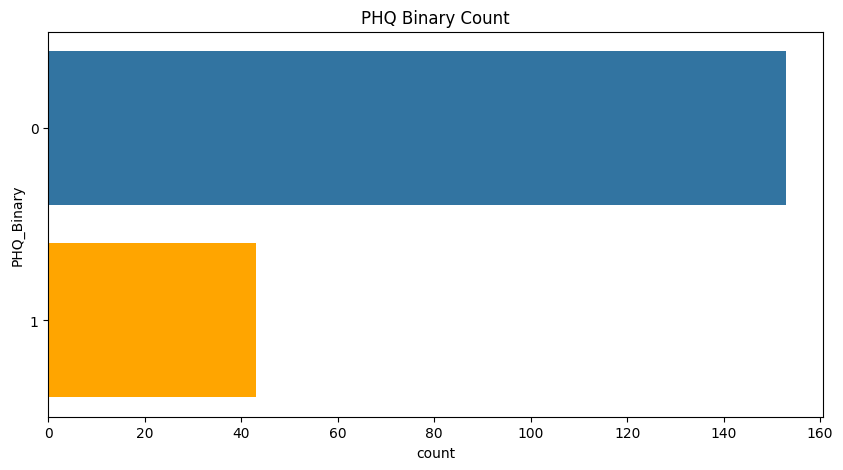

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()

### Oversampling

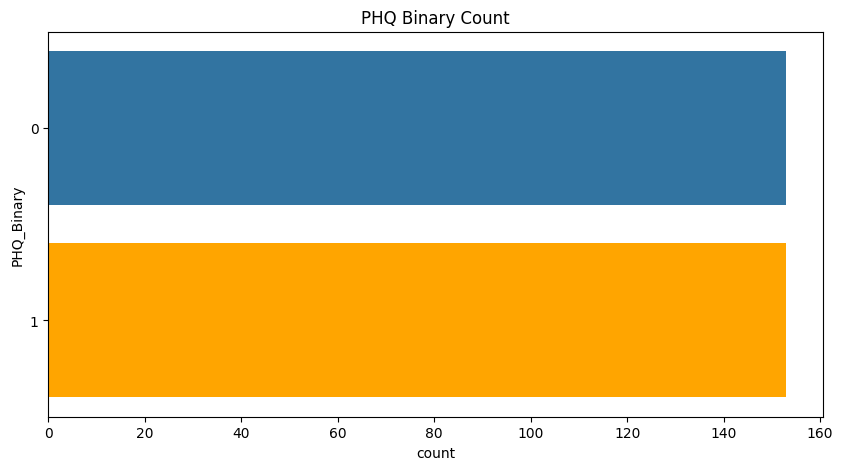

In [ ]:
depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]

# not_depressed = not_depressed.sample(n=len(depressed), random_state=44)
depressed = depressed.sample(n=len(not_depressed), random_state=44, replace=True)

df_b = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df_b = df_b.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df_b)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count')
plt.show()

In [ ]:
df_b = df_b.sort_values(by='Participant_ID')
df_b = df_b.reset_index(drop=True)

df_b.to_csv('audio_balanced.csv', index=False)
df_b.head(10)

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript,Features
0,300,male,0,2,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[0.45782435, -0.16789621, -0.42220274, -0.10..."
1,301,male,0,3,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[-0.7448366, 0.15698695, 0.042065322, -0.233..."
2,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.083217114, 0.5004096, 0.19636308, -0.082..."
3,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.10374418, 0.43084466, 0.035689726, 0.181..."
4,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[0.33124432, -0.22978759, 0.22174521, -0.378..."
5,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.38563088, -0.16254309, -0.6587334, 0.268..."
6,306,female,0,0,/home/smrutibiswal/Research/Dataset/data/valid...,/home/smrutibiswal/Research/Dataset/data/valid...,"[[[0.36333096, -0.5662466, -0.40498564, -0.128..."
7,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[0.27195254, -0.21250738, -0.11973132, -0.37..."
8,308,female,1,22,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.24444392, 0.16161959, 0.08819171, 0.2087..."
9,308,female,1,22,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...,"[[[-0.24444392, 0.16161959, 0.08819171, 0.2087..."


In [ ]:
# sample 77 non depressed participants and 77 depressed participants
depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]
depressed = depressed.sample(n=77, random_state=44, replace=True)
not_depressed = not_depressed.sample(n=77, random_state=44)
df_77 = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df_77 = df_77.sample(frac=1, random_state=44).reset_index(drop=True)
df_77.to_csv('audio_balanced_77.csv', index=False)
print("Balanced dataset saved as audio_balanced_77.csv")

Balanced dataset saved as audio_balanced_77.csv


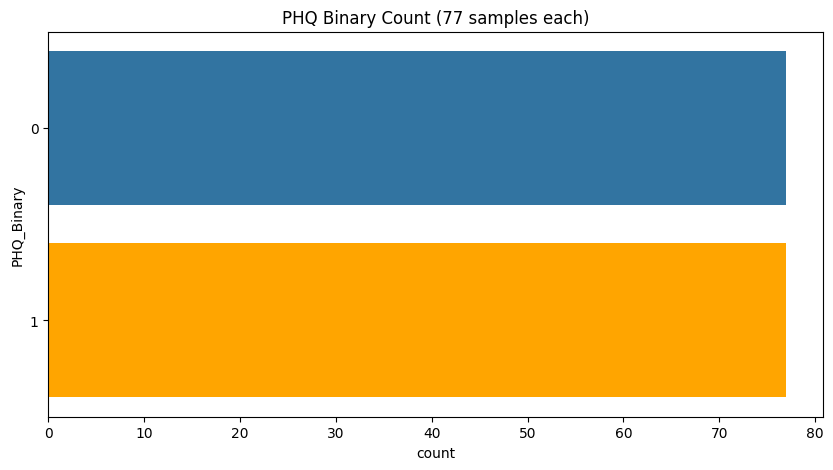

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df_77)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count (77 samples each)')
plt.show()

In [ ]:
train_df.head()

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,Audio_Path,Transcript
0,302,male,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
1,303,female,0,0,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
2,304,female,0,6,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
3,305,male,0,7,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...
4,307,female,0,4,/home/smrutibiswal/Research/Dataset/data/train...,/home/smrutibiswal/Research/Dataset/data/train...


In [ ]:
# for all the participant ids copy the features from df to train df
train_df['Features'] = ''
for i in range(len(train_df)):
    pid = train_df['Participant_ID'][i]
    # copy features from df to train_df while ensuring the shape is (1, 1, 256)
    features = df[df['Participant_ID'] == pid]['Features'].values[0]
    if features.shape == (1, 1, 256):
        train_df['Features'][i] = features
    else:
        print(f"Shape mismatch for {pid}_P in train_df: {features.shape}")
        train_df['Features'][i] = np.zeros((1, 1, 256), dtype=np.float32)
print("Train DataFrame with Features:")
print(train_df.head(5).to_string(index=False))

test_df['Features'] = ''
for i in range(len(test_df)):
    pid = test_df['Participant_ID'][i]
    # copy features from df to test_df while ensuring the shape is (1, 1, 256)
    features = df[df['Participant_ID'] == pid]['Features'].values[0]
    if features.shape == (1, 1, 256):
        test_df['Features'][i] = features
    else:
        print(f"Shape mismatch for {pid}_P in test_df: {features.shape}")
        test_df['Features'][i] = np.zeros((1, 1, 256), dtype=np.float32)
print("Test DataFrame with Features:")
print(test_df.head(5).to_string(index=False))



Train DataFrame with Features:
 Participant_ID  Gender  PHQ_Binary  PHQ_Score                                                          Audio_Path                                                                    Transcript                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
print("Number of samples in traund set: ", len(train_df))
print("Number of samples in test set: ", len(test_df))

Number of samples in traund set:  148
Number of samples in test set:  48


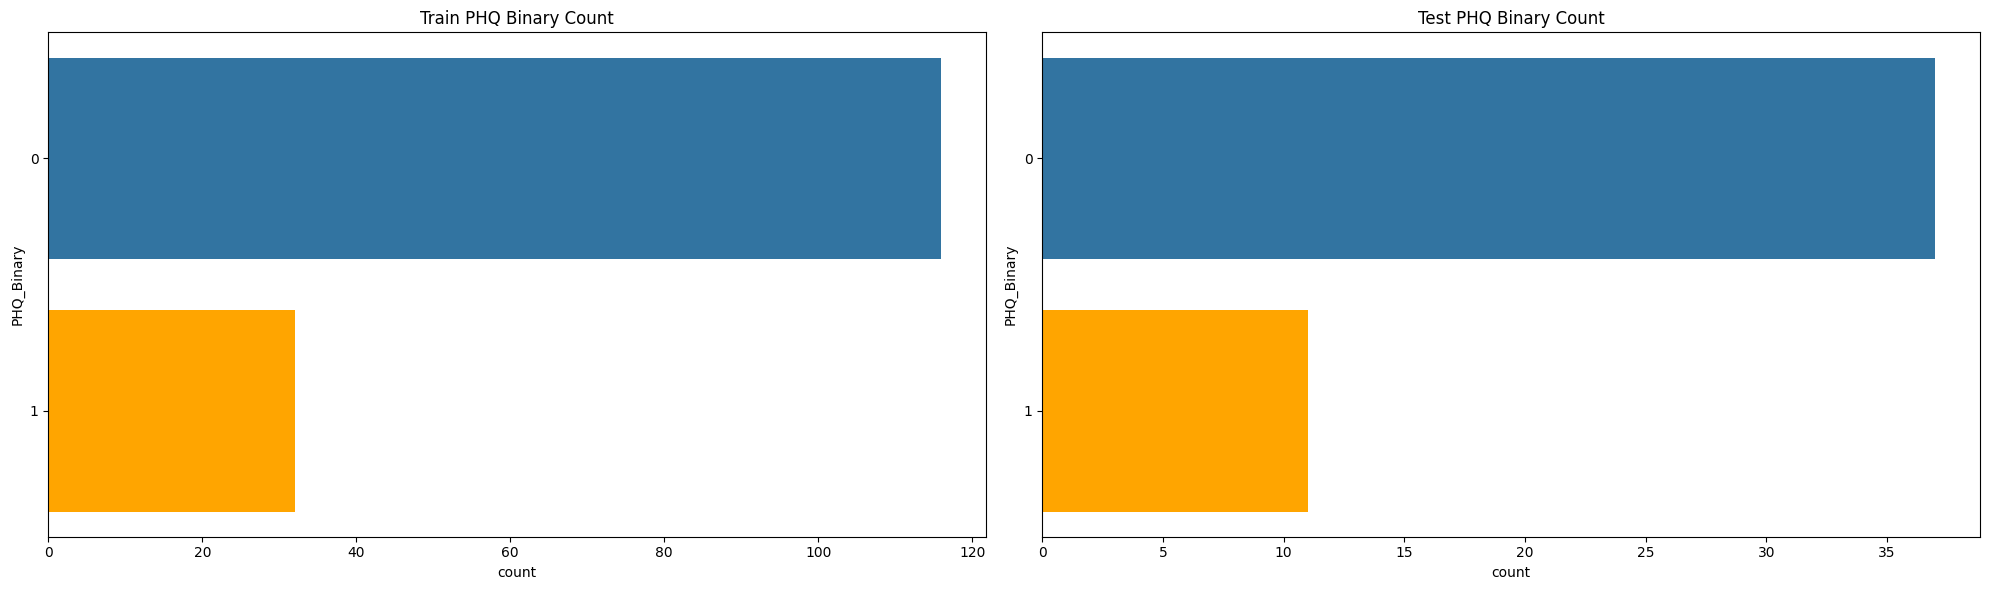

In [ ]:
# train_df depressed and non-depressed count and plot and test_df depressed and non-depressed count and plot beside each other
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='PHQ_Binary', data=train_df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Train PHQ Binary Count')
plt.subplot(1, 2, 2)
sns.countplot(y='PHQ_Binary', data=test_df)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Test PHQ Binary Count')
plt.tight_layout()
plt.show()


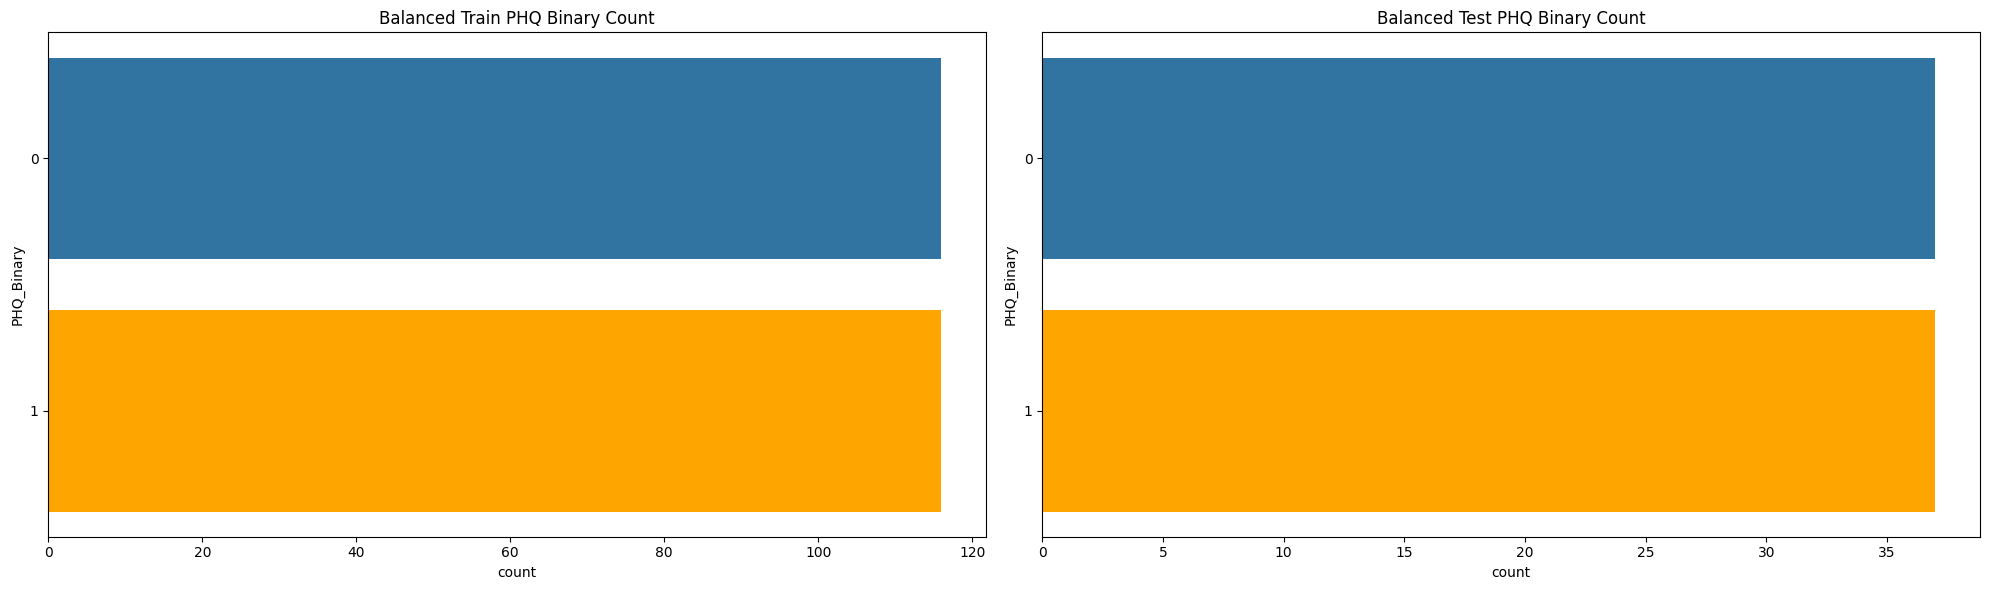

In [ ]:
# balace both train and test set
depressed_train = train_df[train_df['PHQ_Binary'] == 1]
not_depressed_train = train_df[train_df['PHQ_Binary'] == 0]
depressed_train = depressed_train.sample(n=len(not_depressed_train), random_state=44,
                                                replace=True)
train_df_balanced = pd.concat([depressed_train, not_depressed_train], axis=0).reset_index(drop=True)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=44).reset_index(drop=True)

depressed_test = test_df[test_df['PHQ_Binary'] == 1]
not_depressed_test = test_df[test_df['PHQ_Binary'] == 0]
depressed_test = depressed_test.sample(n=len(not_depressed_test), random_state=44,
                                                replace=True)
test_df_balanced = pd.concat([depressed_test, not_depressed_test], axis=0).reset_index(drop=True)
test_df_balanced = test_df_balanced.sample(frac=1, random_state=44).reset_index(drop=True)

#plot this balanced train and test set beside each other
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='PHQ_Binary', data=train_df_balanced)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Balanced Train PHQ Binary Count')
plt.subplot(1, 2, 2)
sns.countplot(y='PHQ_Binary', data=test_df_balanced)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Balanced Test PHQ Binary Count')
plt.tight_layout()
plt.show()


In [ ]:
train_df_balanced.to_csv('train_balanced.csv', index=False)
test_df_balanced.to_csv('test_balanced.csv', index=False)

### Downsampling

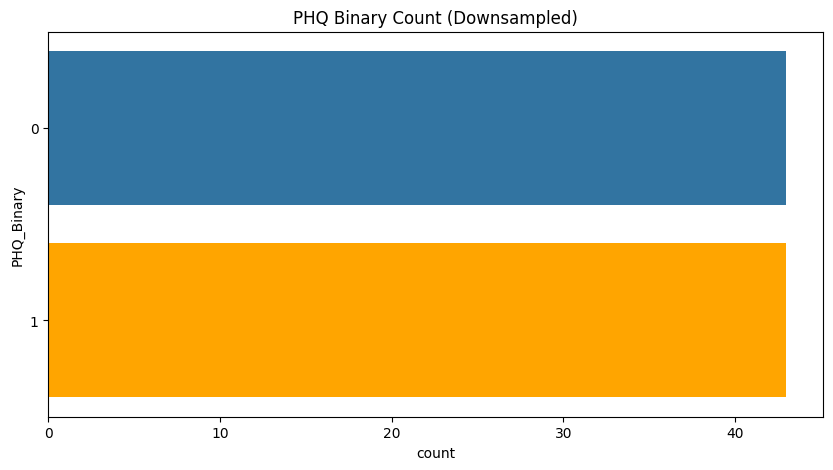

In [ ]:
depressed = df[df['PHQ_Binary'] == 1]
not_depressed = df[df['PHQ_Binary'] == 0]

not_depressed = not_depressed.sample(n=len(depressed), random_state=44)

df_bdown = pd.concat([depressed, not_depressed], axis=0).reset_index(drop=True)
df_bdown = df_bdown.sample(frac=1, random_state=44).reset_index(drop=True)
df_bdown.to_csv('audio_balanced_downsampled.csv', index=False)

plt.figure(figsize=(10, 5))
sns.countplot(y='PHQ_Binary', data=df_bdown)
plt.gca().patches[1].set_facecolor('orange')
plt.title('PHQ Binary Count (Downsampled)')
plt.show()

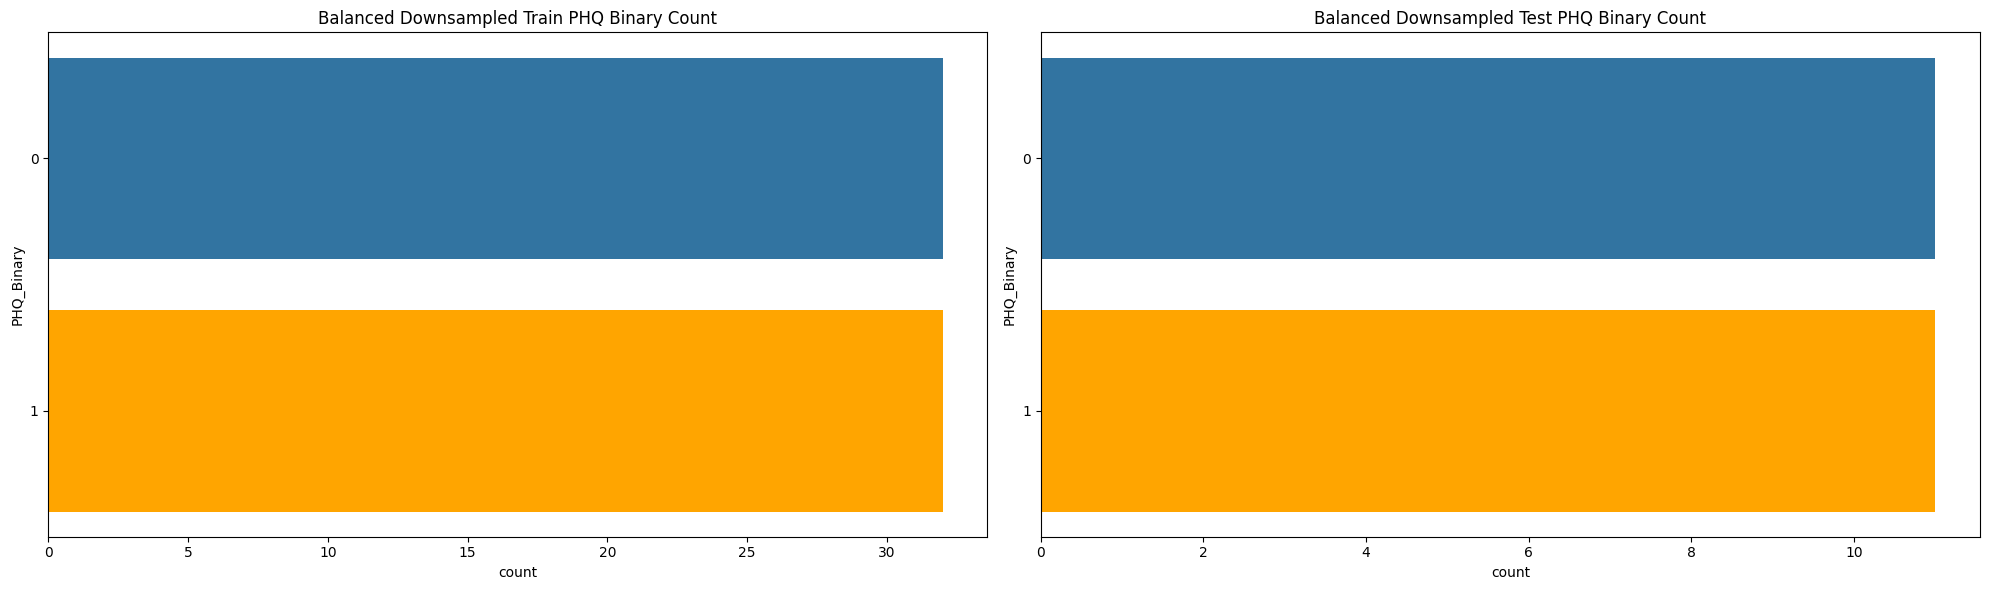

In [ ]:
# balace both train and test set
depressed_train = train_df[train_df['PHQ_Binary'] == 1]
not_depressed_train = train_df[train_df['PHQ_Binary'] == 0]


not_depressed_train = not_depressed_train.sample(n=len(depressed_train), random_state=44)
train_df_bdown = pd.concat([depressed_train, not_depressed_train], axis=0).reset_index(drop=True)
train_df_bdown = train_df_bdown.sample(frac=1, random_state=44).reset_index(drop=True)

depressed_test = test_df[test_df['PHQ_Binary'] == 1]
not_depressed_test = test_df[test_df['PHQ_Binary'] == 0]
not_depressed_test = not_depressed_test.sample(n=len(depressed_test), random_state=44)
test_df_bdown = pd.concat([depressed_test, not_depressed_test], axis=0).reset_index(drop=True)
test_df_bdown = test_df_bdown.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='PHQ_Binary', data=train_df_bdown)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Balanced Downsampled Train PHQ Binary Count')
plt.subplot(1, 2, 2)
sns.countplot(y='PHQ_Binary', data=test_df_bdown)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Balanced Downsampled Test PHQ Binary Count')
plt.tight_layout()
plt.show()

train_df_bdown.to_csv('train_balanced_downsampled.csv', index=False)
test_df_bdown.to_csv('test_balanced_downsampled.csv', index=False)

## Train Test Split




In the model:
1. training data = mfcc  
2. test data = binary score

The train test split will be done in 3 ways:
1. train_test_split from balanced df with 0.8 train and 0.2 test
2. train_test_split from balanced df_77 with 0.8 train and 0.2 test
3. training data is the train_df_balanced and test data is the test_df_balanced

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_b['Features'], df_b['PHQ_Binary'], test_size=0.2, random_state=44)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(244,) (62,) (244,) (62,)


In [ ]:
X_train77, X_test77, y_train77, y_test77 = train_test_split(df_77['Features'], df_77['PHQ_Binary'], test_size=0.2, random_state=44)
print(X_train77.shape, X_test77.shape, y_train77.shape, y_test77.shape)

(123,) (31,) (123,) (31,)


In [ ]:
X_train2 = train_df_balanced['Features']
X_test2 = test_df_balanced['Features']
y_train2 = train_df_balanced['PHQ_Binary']
y_test2 = test_df_balanced['PHQ_Binary']

print(X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape)

(232,) (74,) (232,) (74,)


## Model Building and Architecture

The models used are:
1. GRU
2. BiLSTM

Number of epochs will be 10, 50 and 100

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, Dropout, Flatten, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [ ]:
model = Sequential()
model.add(GRU(64, input_shape=(1, 256), return_sequences=False))  # single time step
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

TypeError: unsupported operand type(s) for /: 'Dimension' and 'int', please use // instead